## Object Detection with the OpenImages v4 classes

The paper to this project is [this](https://openaccess.thecvf.com/content/ICCV2021/papers/Narayan_Discriminative_Region-Based_Multi-Label_Zero-Shot_Learning_ICCV_2021_paper.pdf)<br>
The code is slightly modified copy from the one in the corresponding [github-repository](https://github.com/akshitac8/BiAM)


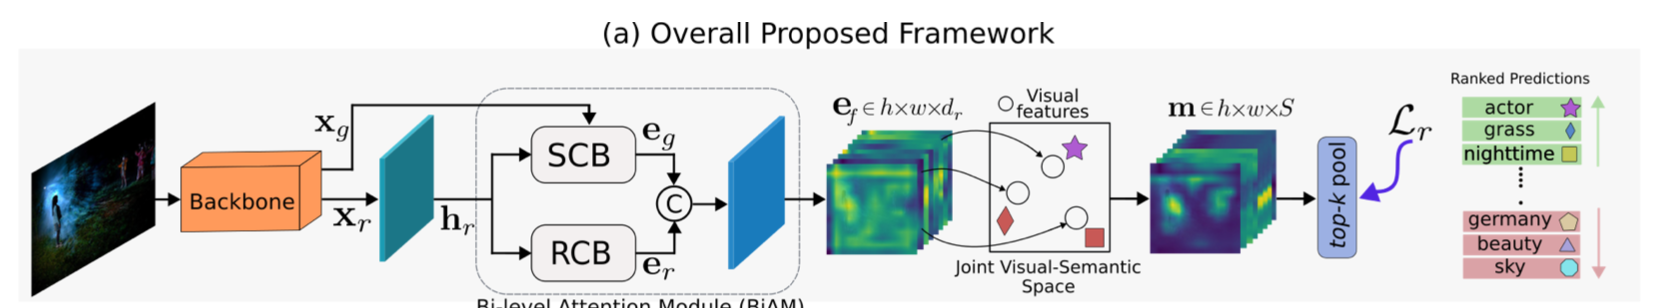

In [1]:
from IPython.display import Image
Image('../images/BiAM1.png')

### Understanding the Backbone
$\mathbf{x}_g$, the global or scene-context features as well as the regional features $\mathbf{x}_r$ are extracted for the different layers of an old-school VVG19 net.

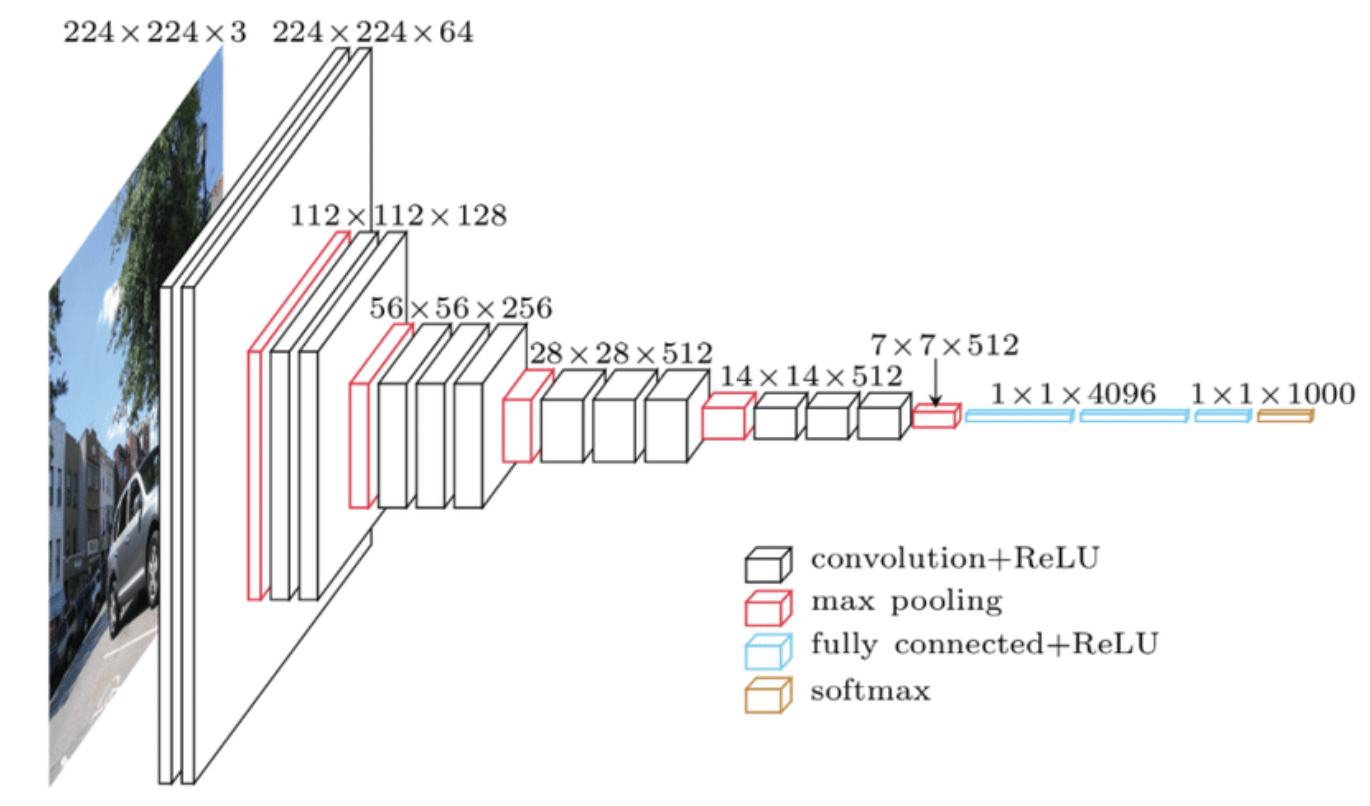

In [2]:
Image('../images/vgg1.png')

In [6]:
torchvision.models.vgg19(True)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [3]:
import torch.nn.functional as F
import torchvision
from torch import nn
import torch


class Net(nn.Module):
    """
    computes regional features (backbone)
    """
    def __init__(self):
        super(Net, self).__init__()
        vgg19 = torchvision.models.vgg19(True)
        
        # all convolutions but the the last MaxPool2d layer
        self.regional_features = nn.Sequential(*list(vgg19.features[:-1]))
    def forward(self, x):
        # image with 224 x 224 x 3 but has to be in pytorch order
        x = x.view(-1, 3, 224, 224)
        return self.regional_features(x)

       
    
class vgg_net(nn.Module):
    """
    applies the last MaxPool2d to the backbone 'regional' features
    and passes them through part of the classifier to get a 4096
    contextual feature-vector
    """
    def __init__(self):
        super(vgg_net, self).__init__()
        vgg19 = torchvision.models.vgg19(True)
        # only MaxPool2d operation
        self.features = nn.Sequential(*list(vgg19.features[-1:]))
                        
        # classifier without the last Dropout and linear-layer 4096 -> 1000
        self.fc = nn.Sequential(*list(vgg19.classifier[0:-2]))
                  
        ## nnlist = []
        ## nnlist.append(vgg19.features[36])
        ## for i in list(vgg19.classifier[0:5]):
        ##     nnlist.append(i)
        ## self.fc = nn.Sequential(*nnlist)

    def forward(self, x):
        x = x.view([-1,512,14,14])
        x = self.features(x)
        # x = x.view(x.size(0),-1)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x
    
class Vgg(nn.Module):
    """
    takes contextual features and classifies in 1000 imagenet categories
    """
    def __init__(self):
        super(Vgg, self).__init__()
        vgg19 = torchvision.models.vgg19(True)
        self.final_classifier = nn.Sequential(*list(vgg19.classifier[-2:]))
    def forward(self, x):
        # input is batch-size, contextual-feature vector
        x = x.view(-1, 4096)
        return self.final_classifier(x)



In [ ]:
vgg19 = torchvision.models.vgg19(True)
vgg19

In [ ]:
Image('../images/vgg2.png')

### Joint Visual-Semantic Space

The target of the BiAM-Network are the Glove-embeddings of the OpenImages-Labels. The Network is trained to output embedding-vectors that are as near as possible to the embeddings of the labels.<br>
This is also how the zero-shot learning takes place.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import random
import torchvision
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


class Net(nn.Module):
    """
    computes regional features (backbone)
    """
    def __init__(self):
        super(Net, self).__init__()
        vgg19 = torchvision.models.vgg19(True)
        
        # all convolutions but the the last MaxPool2d layer
        self.regional_features = nn.Sequential(*list(vgg19.features[:-1]))
    def forward(self, x):
        # image with 224 x 224 x 3 but has to be in pytorch order
        x = x.view(-1, 3, 224, 224)
        return self.regional_features(x)
    
class Vgg(nn.Module):
    """
    takes contextual features and classifies in 1000 imagenet categories
    """
    def __init__(self):
        super(Vgg, self).__init__()
        vgg19 = torchvision.models.vgg19(True)
        self.final_classifier = nn.Sequential(*list(vgg19.classifier[-2:]))
    def forward(self, x):
        # input is batch-size, contextual-feature vector
        x = x.view(-1, 4096)
        return self.final_classifier(x)

class vgg_net(nn.Module):
    """
    applies the last MaxPool2d to the backbone 'regional' features
    and passes them through part of the classifier to get a 4096
    contextual feature-vector
    """
    def __init__(self):
        super(vgg_net, self).__init__()
        vgg19 = torchvision.models.vgg19(True)
        # only MaxPool2d operation
        self.features = nn.Sequential(*list(vgg19.features[-1:]))
        # classifier without the last Dropout and linear-layer 4096 -> 1000
        self.fc = nn.Sequential(*list(vgg19.classifier[0:-2]))

    def forward(self, x):
        x = x.view([-1,512,14,14])
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x


random.seed(3483)
np.random.seed(3483)
torch.manual_seed(3483)
torch.cuda.manual_seed(3483)
torch.cuda.manual_seed_all(3483)

def tensordot(x,y):
    return torch.matmul(x, y)
    # return torch.einsum("abc,cd->abd", (x, y))


def matmul(x,y):
    return torch.matmul(x, y)
    # return torch.einsum("ab,bc->ac", (x, y))

class CONV3_3(nn.Module):
    def __init__(self, num_in=512,num_out=512,kernel=3):
        super(CONV3_3, self).__init__()
        self.body = nn.Conv2d(num_in, num_out, kernel, padding=int((kernel-1)/2), dilation=1)
        self.bn = nn.BatchNorm2d(num_out, affine=True, eps=0.001, momentum=0.99)
        self.relu = nn.ReLU(True)
    def forward(self, x):
        x = self.body(x)
        x = self.relu(x)
        x = self.bn(x) 
        return x

class CONV1_1(nn.Module):
    def __init__(self, num_in=512,num_out=512,kernel=1):
        super(CONV1_1, self).__init__()
        self.body = nn.Conv2d(num_in, num_out, kernel, padding=int((kernel-1)/2), dilation=1)
    def forward(self, x):
        x = self.body(x)
        return x

class vgg_net(nn.Module):
    def __init__(self):
        super(vgg_net, self).__init__()
        vgg19 = torchvision.models.vgg19(True)
        self.features = nn.Sequential(*list(vgg19.features[-1:]))
        self.fc = nn.Sequential(*list(vgg19.classifier[0:-2]))

    def forward(self, x):
        x = x.view([-1,512,14,14])
        x = self.features(x)
        x = x.reshape(x.size(0),-1)
        x = self.fc(x)
        return x

class RCB(nn.Module):
    """
    Region contextualized block
    """
    def __init__(self, heads=8, d_model=512, d_ff=1024, dropout = 0.1):
        super(RCB, self).__init__()
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        self.w_q = nn.Conv2d(in_channels = d_model , out_channels = d_model , kernel_size=1, bias=True)
        self.w_k = nn.Conv2d(in_channels = d_model , out_channels = d_model , kernel_size=1, bias=True)
        self.w_v = nn.Conv2d(in_channels = d_model, out_channels = d_model, kernel_size=1, bias=True)
        self.w_o = nn.Conv2d(in_channels = d_model , out_channels = d_model , kernel_size=1, bias=True)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.sub_network = C_R(d_model, d_ff)

    def F_R(self, q, k, v, d_k, dropout=None):
        scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
        #scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.Tensor([d_k])) #math.sqrt(d_k)
        #scores = torch.div(torch.matmul(q, k.transpose(-2, -1)), torch.sqrt(torch.Tensor([d_k]))) #math.sqrt(d_k)
        scores = scores.masked_fill(scores == 0, -1e9)
        scores = F.softmax(scores, dim=-1)
        if dropout is not None:
            scores = dropout(scores) 
        return scores

    def forward(self, q_feat, k_feat, v_feat):
        if k_feat is None:
            k_feat = q_feat
        bs = q_feat.size(0)
        spa = q_feat.size(-1)
        residual = q_feat
        k_h_r = self.w_k(k_feat).view(bs, self.h, self.d_k, spa*spa).transpose(3,2)
        q_h_r = self.w_q(q_feat).view(bs, self.h, self.d_k, spa*spa).transpose(3,2)
        v_h_r = self.w_v(v_feat).view(bs, self.h, self.d_k, spa*spa).transpose(3,2)
        r_h = self.F_R(q_h_r, k_h_r, v_h_r, self.d_k, self.dropout_1)
        alpha_h = torch.matmul(r_h, v_h_r)
        o_r = alpha_h.transpose(1,2).contiguous().view(bs, -1, self.d_model)
        o_r = o_r.permute(0,2,1)
        o_r = o_r.view(-1,self.d_model,spa,spa)
        o_r = self.dropout_2(self.w_o(o_r))
        o_r += residual
        input_o_r = o_r
        e_r = self.sub_network(o_r)
        e_r += input_o_r
        return e_r

class C_R(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = d_model , out_channels = d_ff , kernel_size= 1, bias=True)
        self.conv2 = nn.Conv2d(in_channels = d_ff , out_channels = d_model , kernel_size= 1, bias=True)
    def forward(self, x):
        x_out = self.conv2(F.relu(self.conv1(x), True))
        return x_out

class SCB(nn.Module):
    """
    scene contextualized block
    """
    def __init__(self, opt, D):
        super(SCB, self).__init__()
        self.channel_dim = opt.channel_dim
        self.sigmoid = nn.Sigmoid()
        self.gcdropout = nn.Dropout(0.2)
        self.lrelu = nn.LeakyReLU(0.2, False)
        self.w_g = nn.Conv2d(in_channels=4096,out_channels=self.channel_dim,kernel_size=1,bias=True) #nn.Linear(4096, self.channel_dim, bias=False) # 
        self.gcff = CONV3_3(num_in=self.channel_dim, num_out=self.channel_dim)
        self.channel_conv = CONV1_1(num_in=self.channel_dim, num_out=self.channel_dim)

    def F_G(self, q , k):
        r_g = q * k
        r_g = self.sigmoid(r_g)     
        r_g = r_g.view(-1,self.channel_dim,1)
        return r_g

    def forward(self, h_r, vecs, x_g):
        # import pdb;pdb.set_trace()
        q_g = self.lrelu(self.channel_conv(h_r))
        v_g =  self.lrelu(self.channel_conv(h_r))
        k_g = self.w_g(self.gcdropout(x_g).view(-1,4096,1,1))
        # k_g = self.w_g(self.gcdropout(x_g))
        q_g_value = q_g.view(-1,self.channel_dim,196).mean(-1).repeat(1,1,1).view(-1,self.channel_dim)
        r_g = self.F_G(q_g_value,k_g.view(-1,self.channel_dim))
        # r_g = self.F_G(q_g_value,k_g)
        c_g = r_g.unsqueeze(3).unsqueeze(4) * v_g.unsqueeze(2)
        c_g = c_g.view(-1,self.channel_dim,14,14)
        e_g = c_g + self.gcff(c_g)
        return e_g

class BiAM(nn.Module):
    def __init__(self, opt, dim_w2v=300, dim_feature=[196,512]):
        super(BiAM, self).__init__()
        D = dim_feature[1]     #### D is the feature dimension of attention windows
        self.channel_dim = opt.channel_dim
        self.conv_3X3 = CONV3_3(num_out=self.channel_dim)
        self.region_context_block = RCB(heads=opt.heads, d_model=self.channel_dim, d_ff=self.channel_dim*2, dropout = 0.1)
        self.scene_context_block = SCB(opt, D)
        self.W = nn.Linear(dim_w2v,D, bias=True)
        self.conv_1X1 = CONV1_1(num_in=self.channel_dim*2, num_out=D)
        self.lrelu = nn.LeakyReLU(0.2, True)

    def predict(self, e_f, vecs, W):
        classifiers = W(vecs)                                 
        m = tensordot(e_f, classifiers.t())                                   
        logits = torch.topk(m,k=6,dim=1)[0].mean(dim=1)
        return logits
        
    def forward(self, features, vecs, x_g):
        # import pdb;pdb.set_trace()
        x_r = features.view([-1,512,14,14])
        h_r = self.conv_3X3(x_r)
        e_r = self.region_context_block(h_r,h_r,h_r)
        e_g = self.scene_context_block(h_r, vecs, x_g)
        e_f = torch.cat([e_r, e_g], dim=1)
        e_f = self.lrelu(self.conv_1X1(e_f))
        e_f = e_f.permute(0,2,3,1)
        e_f = e_f.view(-1,196,512)
        logits = self.predict(e_f, vecs, self.W)
        return logits

def ranking_lossT(logitsT, labelsT):
    eps = 1e-8
    subset_idxT = torch.sum(torch.abs(labelsT),dim=0)
    subset_idxT = (subset_idxT>0).nonzero().view(-1).long().cuda()
    sub_labelsT = labelsT[:,subset_idxT]
    sub_logitsT = logitsT[:,subset_idxT]    
    positive_tagsT = torch.clamp(sub_labelsT,0.,1.)
    negative_tagsT = torch.clamp(-sub_labelsT,0.,1.)
    maskT = positive_tagsT.unsqueeze(1) * negative_tagsT.unsqueeze(-1)
    pos_score_matT = sub_logitsT * positive_tagsT
    neg_score_matT = sub_logitsT * negative_tagsT
    IW_pos3T = pos_score_matT.unsqueeze(1)
    IW_neg3T = neg_score_matT.unsqueeze(-1)
    OT = 1 + IW_neg3T - IW_pos3T
    O_maskT = maskT * OT
    diffT = torch.clamp(O_maskT, 0)
    violationT = torch.sign(diffT).sum(1).sum(1) 
    diffT = diffT.sum(1).sum(1) 
    lossT =  torch.mean(diffT / (violationT+eps))
    return lossT


In [8]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--lr', type=float, default=0.001 ,help='initial learning rate')
parser.add_argument('--lr_min', type=float, default=0.0002 ,help='minimum lr for scheduler drop')
parser.add_argument('--train_full_lr', type=float, default=0.0002 ,help='lr for finetuning')
parser.add_argument('--workers', type=int,help='number of data loading workers', default=0)
parser.add_argument('--manualSeed', type=int, help='manual seed')
parser.add_argument('--cuda', action='store_true',default=True, help='enables cuda')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
parser.add_argument('--nepoch', type=int, default=2000, help='number of epochs to train for')
parser.add_argument('--train', action='store_true',default=False, help='enables cuda')
parser.add_argument('--train_full_data', action='store_true',default=False, help='Only train a pretrained model')

parser.add_argument('--eval_interval', type=int, default=2)
parser.add_argument('--test_interval', type=int, default=10)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--val_batch_size', type=int, default=500)
parser.add_argument('--test_batch_size', type=int, default=500)


parser.add_argument('--save_path', type=str, default='test dataset type 2 split', help='details regarding the code')
parser.add_argument('--SESSION', type=str, default='SA_LRANK', help='MODEL NAME')
parser.add_argument('--job_id', type=str, default='14567', help='file job id')

parser.add_argument('--heads', type=int, default=4, help='Heads for region Atn')

parser.add_argument('--cosinelr_scheduler', action='store_true',default=False, help='Run with lr scheduler')
parser.add_argument('--summary', type=str, default='Summary', help='Summary of Expt')
parser.add_argument('--src', type=str,default="../../../../data")

parser.add_argument('--nseen_class', type=int, default=925,help='number of seen classes')
parser.add_argument('--nclass_all', type=int, default=1006,help='number of all classes')

parser.add_argument('--channel_dim', type=int, default=256,help='conv channel dim')

# opt = parser.parse_args()
opt, unknown = parser.parse_known_args()


In [9]:
biam_model_path = '/home/martin/python/fhnw_lecture/data'
glove_vectors = 'OpenImage_w2v_context_window_10_glove-wiki-gigaword-300.pkl'

In [11]:
from sklearn.preprocessing import normalize
import pickle
import os
biam = BiAM(opt, dim_feature=[196,512])
biam.load_state_dict(torch.load(os.path.join(biam_model_path, 'model_BiAM.pth'),map_location=torch.device('cpu')))

src_att = pickle.load(open(os.path.join(biam_model_path, glove_vectors), 'rb'))
vecs_7186 = torch.from_numpy(normalize(src_att[0]))

In [12]:
import pandas as pd
import os
all_classes = pd.read_csv(os.path.join(biam_model_path, 'OpenImages/class-descriptions.csv'), header=None)
all_classes.columns = ['id', 'object']

In [13]:
trainable = pd.read_csv(os.path.join(biam_model_path, 'OpenImages/classes-trainable.txt'), header=None)
trainable.columns = ['id']

In [14]:
class_labels = all_classes.merge(trainable, on='id', how='inner')

In [15]:
class_labels = class_labels[['object']].values.reshape(-1)

In [16]:
import json
import ast
with open('/home/martin/python/fhnw_lecture/data/imagenet1000_clsidx_to_labels.txt', 'r') as tap:
    imagenet_cls = tap.read()
    
imagenet_cls = ast.literal_eval(imagenet_cls)    

imagenet_cls = np.asarray(list(imagenet_cls.values()))

In [17]:
contextual = vgg_net()
backbone = Net()
image_net_clf = Vgg()
biam.eval()
contextual.eval()
backbone.eval()
image_net_clf.eval()


Vgg(
  (final_classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=1000, bias=True)
  )
)

In [18]:
import torchvision.transforms as transforms
from io import BytesIO
import requests
from PIL import Image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # bilinear interpolation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [19]:
from bs4 import BeautifulSoup

import re
#'https://unsplash.com/s/photos/random-objects'
response = requests.get('https://unsplash.com/s/photos/random-objects')
soup = BeautifulSoup(response.text)
images = []
for img in soup.findAll('img'):
    images.append(img.get('src'))

print(images)


['https://sb.scorecardresearch.com/p?c1=2&c2=32343279&cv=2.0&cj=1', 'https://media.istockphoto.com/photos/candy-jar-close-up-picture-id1015354484?b=1&k=20&m=1015354484&s=170667a&w=0&h=v-NKMNC5OMKNGPrfPMMcqWYPvZXP8QNvao_OjGdE9Yg=', 'https://media.istockphoto.com/photos/bananas-on-blue-background-picture-id666476790?b=1&k=20&m=666476790&s=170667a&w=0&h=0o5ramTtcfbYyakqU05CTQsyhx9TK09DUKK-salSCQQ=', 'https://media.istockphoto.com/photos/left-behind-picture-id157402340?b=1&k=20&m=157402340&s=170667a&w=0&h=68NVsFjq4-BJOFomMrFInIj_K4bMXS2Otbb7mMTYTrA=', 'https://media.istockphoto.com/photos/stack-of-books-isolated-on-white-background-picture-id165970461?b=1&k=20&m=165970461&s=170667a&w=0&h=ZhKdSVbP4DdFPBe_xxezAvtnhhKoVBwgxp9T5k08-tI=', 'https://media.istockphoto.com/photos/candy-jar-close-up-picture-id1015354484?b=1&k=20&m=1015354484&s=170667a&w=0&h=v-NKMNC5OMKNGPrfPMMcqWYPvZXP8QNvao_OjGdE9Yg=', 'https://media.istockphoto.com/photos/bananas-on-blue-background-picture-id666476790?b=1&k=20&m=6

[('Elapidae', 0.15119511), ('Ammonoidea', 0.019929653), ('Bronze sculpture', 0.017255886), ('Karahi', 0.0134023), ('Tortoise', 0.0104936585), ('Ceramic', 0.010280835), ('Pottery', 0.0064476016), ('Gerbil', 0.0062165265), ('Burger king premium burgers', 0.0049137156), ('Silver', 0.004215729)]
[('terrapin', 0.9921228), ('mud turtle', 0.0045102187), ('leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea', 0.0007781333), ('box turtle, box tortoise', 0.0007701893), ('pickelhaube', 0.00039786732)]


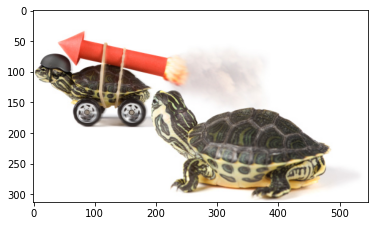

[('Chest of drawers', 0.023053851), ('Stool', 0.016910471), ('Carpet', 0.009413461), ('Desk', 0.009112548), ('Rug', 0.0072767786), ('Wardrobe', 0.007012216), ('Quilting', 0.0049007586), ('Kitchen & dining room table', 0.0044372394), ('Burger king premium burgers', 0.0043493146), ('Cabinetry', 0.0039726137)]
[('rocking chair, rocker', 0.79516834), ('folding chair', 0.07630475), ('dining table, board', 0.022533776), ('throne', 0.019699758), ('pedestal, plinth, footstall', 0.019332405)]


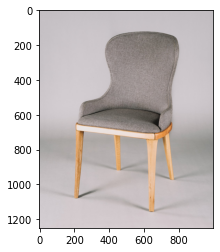

[('Chutney', 0.20134383), ('Apple juice', 0.02785346), ('Sorbet', 0.017476963), ('Common bean', 0.016944772), ('Juice', 0.015755584), ('Cantaloupe', 0.013467595), ('Spinach', 0.0075351275), ('Kitchen utensil', 0.0070068277), ('Stemware', 0.0063808705), ('Burger king premium burgers', 0.0057959473)]
[('fig', 0.4947853), ('acorn', 0.14268568), ('lemon', 0.12442062), ('cucumber, cuke', 0.1121448), ('Granny Smith', 0.07041185)]


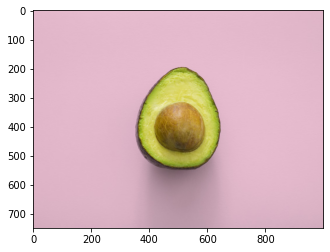

[('Twenty20', 0.013296825), ('Burger king premium burgers', 0.0045969756), ('Coca-cola', 0.0042696325), ('Shoal', 0.0038217825), ('Pitch', 0.003404413), ('Candle holder', 0.0032343485), ('Blended whiskey', 0.0032268497), ('Yellow garden spider', 0.003196299), ('Verrine', 0.0030564247), ('Cocktail', 0.0029251412)]
[('balloon', 0.24938974), ('orange', 0.11861482), ('pill bottle', 0.06571694), ('hip, rose hip, rosehip', 0.053287305), ("jack-o'-lantern", 0.05031725)]


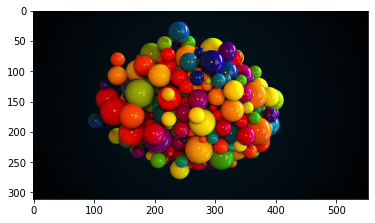

[('Battery', 0.008799058), ('Mug', 0.006530037), ('Burger king premium burgers', 0.005372735), ('Coloring book', 0.005251306), ("Potter's wheel", 0.004943271), ('Portable media player', 0.0047760764), ('Kitchen utensil', 0.0038739871), ('Jug', 0.0038431718), ('Desk', 0.0036732599), ('Ipod', 0.0036702573)]
[('cup', 0.22597101), ('digital clock', 0.21559754), ('iPod', 0.12738709), ('coffee mug', 0.10922295), ('dumbbell', 0.033707574)]


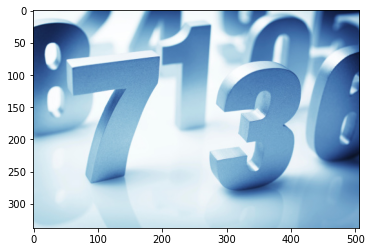

[('Drawing', 0.01588061), ('Mug', 0.010533144), ('Pen', 0.009799067), ('Printmaking', 0.008939856), ('Ceramic', 0.008776976), ('Doodle', 0.0075172368), ('Stencil', 0.007087973), ('Broadcasting', 0.005967064), ('Kitchen utensil', 0.00518025), ('Cup', 0.004735591)]
[('piggy bank, penny bank', 0.35952112), ('football helmet', 0.17346618), ('thimble', 0.09733234), ('saltshaker, salt shaker', 0.09018355), ('golf ball', 0.032772895)]


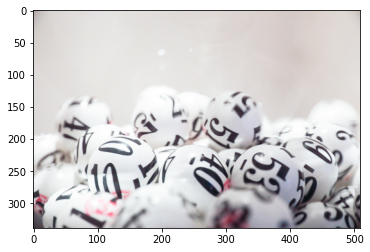

[('Plastic bottle', 0.015901279), ('Hamper', 0.009953145), ('Orange', 0.008959481), ('Orange', 0.008454964), ('Greengrocer', 0.005314738), ('Mofletta', 0.0050100307), ('Classic cocktail', 0.00450115), ('Berry', 0.0043845526), ('New england clam bake', 0.004353653), ('Prickly pear', 0.0041814805)]
[('corn', 0.8234839), ('confectionery, confectionary, candy store', 0.061889887), ('ping-pong ball', 0.01799184), ('ear, spike, capitulum', 0.015674366), ('dough', 0.00971919)]


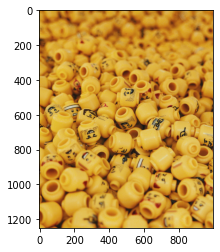

[('Rock', 0.022201397), ('Slate', 0.013786348), ('Quarry', 0.01298025), ('Slate', 0.0094449585), ('Strata', 0.0087625), ('Bedrock', 0.0078034746), ('Monolith', 0.0074958378), ('Pencil', 0.0073802928), ('Pebble', 0.007281486), ('Gemstone', 0.0072567547)]
[('bottlecap', 0.24665894), ('nail', 0.14718175), ('sea urchin', 0.071621634), ('conch', 0.06406573), ('lumbermill, sawmill', 0.062847026)]


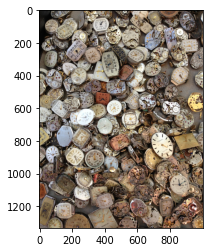

[('Eschscholzia californica', 0.0076990845), ('Flag', 0.0028043943), ('Signage', 0.0027123897), ('Graphic design', 0.0026666212), ('Pitch', 0.0024296795), ('Pastel', 0.0023869334), ('Address sign', 0.002198804), ('Watercolor paint', 0.0021587212), ('Oval', 0.0020555118), ('Downtown', 0.0020500948)]
[('comic book', 0.14686252), ('jigsaw puzzle', 0.113386594), ('tray', 0.06446286), ('wall clock', 0.052233223), ('coral reef', 0.036599565)]


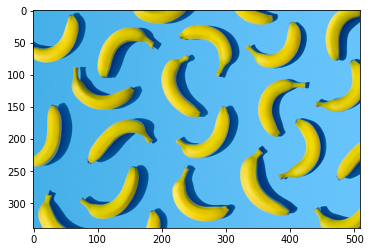

[('Pitch', 0.015726756), ('Parrot', 0.012045084), ('Foal', 0.007488983), ('American Mourning Dove', 0.006244326), ('Blended whiskey', 0.0054462017), ('Human arm', 0.004976341), ('Verrine', 0.0049755354), ('Vegetation', 0.004618111), ('Twenty20', 0.004367597), ('Oval', 0.003998319)]
[('cock', 0.8497619), ('prairie chicken, prairie grouse, prairie fowl', 0.04207158), ('partridge', 0.028611958), ('hen', 0.021293994), ('black grouse', 0.021094922)]


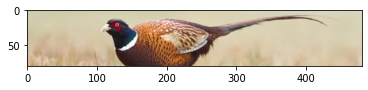

[('Flash', 0.005918783), ('Moustache', 0.005783398), ('Online advertising', 0.0052920026), ('Blended whiskey', 0.0052800374), ('Signature', 0.0050281836), ('Presentation', 0.004697925), ('Advertising', 0.0046304967), ('Media', 0.0043322714), ('Banner', 0.004315471), ('Stout', 0.0043046083)]
[('whiskey jug', 0.0665375), ('pick, plectrum, plectron', 0.061100386), ('oil filter', 0.060824227), ('book jacket, dust cover, dust jacket, dust wrapper', 0.030384589), ('digital clock', 0.024721937)]


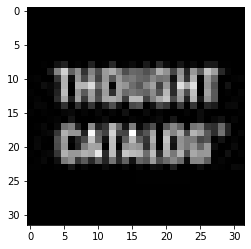

[('Bicycle pedal', 0.009258103), ('Stairs', 0.0066164644), ('Turbine', 0.006464751), ('Airport terminal', 0.0064554787), ('Jug', 0.005823508), ('Roast beef', 0.005117582), ('Latte', 0.0046766475), ('Oval', 0.00453755), ('Burger king premium burgers', 0.004171223), ('Tram', 0.004041406)]
[('wall clock', 0.7385113), ('magnetic compass', 0.21580179), ('analog clock', 0.040165547), ('barometer', 0.0017590666), ('French horn, horn', 0.0008945549)]


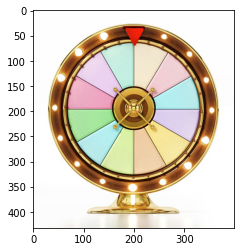

[('Mug', 0.27701855), ('Ceramic', 0.09618035), ('Kitchen utensil', 0.051809553), ('Cup', 0.027432894), ('Cup', 0.023970207), ('Jug', 0.016520375), ('Beer glass', 0.013304519), ('Teacup', 0.012276017), ('Chutney', 0.012271896), ('Frozen dessert', 0.01016956)]
[('pill bottle', 0.38077798), ('mixing bowl', 0.07977035), ('lemon', 0.061164442), ('saltshaker, salt shaker', 0.04951646), ('cup', 0.04269319)]


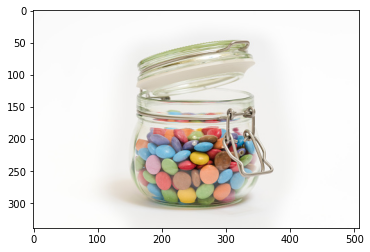

[('Burger king premium burgers', 0.0093340045), ('Drawing', 0.008906433), ('Touchpad', 0.005015846), ('Blended whiskey', 0.0039769276), ('Pencil case', 0.0038482186), ('Feature phone', 0.003817444), ('Smartphone', 0.003795881), ('Ristretto', 0.003794675), ('Coca-cola', 0.0036301564), ('Guitar amplifier', 0.0035364896)]
[('maraca', 0.3491049), ('hair slide', 0.14282694), ('pencil sharpener', 0.13264574), ('saltshaker, salt shaker', 0.12986584), ('strainer', 0.04677319)]


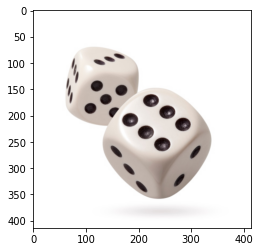

[('Tennis Equipment', 0.037081566), ('Net sports', 0.008583769), ('Hitting a ball', 0.007877528), ('Volleyball', 0.00637653), ('Racquet sport', 0.005731947), ('Portable media player', 0.0056400197), ('Volleyball', 0.005581006), ('Volleyball net', 0.00542224), ('Holding hands', 0.004965308), ('Volkswagen golf', 0.003521869)]
[('bubble', 0.38876292), ('water bottle', 0.11800546), ('perfume, essence', 0.08290243), ('hourglass', 0.06694521), ('spotlight, spot', 0.055466563)]


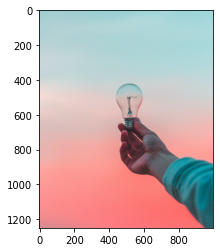

[('Portable media player', 0.12678385), ('Touchpad', 0.03866532), ('Portable communications device', 0.029129904), ('Watch phone', 0.014831173), ('Vehicle audio', 0.014144778), ('Iphone', 0.012239552), ('Audio equipment', 0.012217423), ('Usb flash drive', 0.0083894115), ('Fire extinguisher', 0.0079024), ('Mobile phone', 0.0075267097)]
[('cassette', 0.296103), ('switch, electric switch, electrical switch', 0.19348164), ('cassette player', 0.07757151), ('Polaroid camera, Polaroid Land camera', 0.07651942), ('pencil sharpener', 0.07133932)]


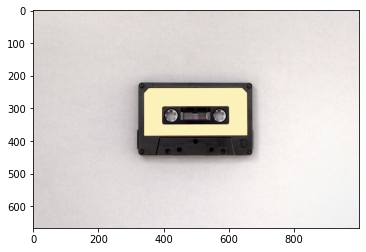

[('Shoal', 0.005952344), ('Couch', 0.005195554), ('Desk', 0.004438513), ('Tennis Equipment', 0.004294577), ('Stool', 0.004007812), ('Night', 0.003947187), ('Twenty20', 0.0027107543), ('Evening', 0.0026240603), ('Kayaking', 0.0025927527), ('Morning', 0.0025258907)]
[('water tower', 0.41781542), ('table lamp', 0.1819591), ('balloon', 0.072181255), ('spotlight, spot', 0.06635693), ('ping-pong ball', 0.04223268)]


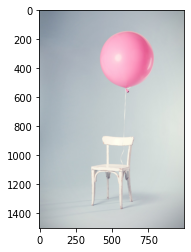

[('Stationery', 0.004804485), ('Burger king premium burgers', 0.004442167), ('Signature', 0.0038962965), ('Moustache', 0.003796221), ('Coffee cup sleeve', 0.0033058205), ('Ipod', 0.0032301822), ("Rubik's cube", 0.0029461507), ('Embellishment', 0.0028236005), ('Ipad', 0.0028047762), ('Drawing', 0.0027660998)]
[('hair slide', 0.2555642), ('Band Aid', 0.055866554), ('rubber eraser, rubber, pencil eraser', 0.04149823), ('maraca', 0.038118996), ('whistle', 0.026783563)]


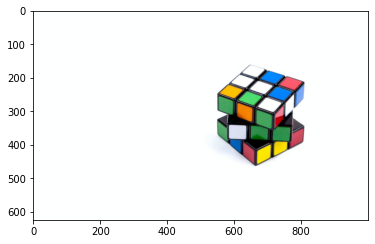

[('Ball', 0.004784894), ('Ball', 0.004769876), ('Corn starch', 0.0025111646), ('Ceramic', 0.002415228), ('Darkness', 0.0022419323), ('Black-and-white', 0.0021323643), ('Smoke', 0.0020917628), ('Propeller', 0.0019834358), ('Drop', 0.0018996552), ('Rave', 0.0018518529)]
[('corkscrew, bottle screw', 0.18671255), ('screw', 0.14208406), ('syringe', 0.113168396), ('can opener, tin opener', 0.0846789), ('screwdriver', 0.060836006)]


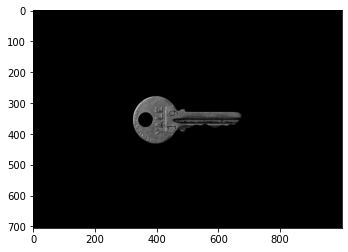

[('Pitch', 0.007995149), ('Black-and-white', 0.004819668), ('Twenty20', 0.004721271), ('Rave', 0.004535987), ('Darkness', 0.0039733388), ('Woodwind instrument', 0.003878279), ('Hearing', 0.003496458), ('Agave nectar', 0.0029291234), ('Twig', 0.002826702), ('Blended whiskey', 0.0026825767)]
[('siamang, Hylobates syndactylus, Symphalangus syndactylus', 0.051945165), ('colobus, colobus monkey', 0.04916332), ('Sealyham terrier, Sealyham', 0.04281289), ('sloth bear, Melursus ursinus, Ursus ursinus', 0.03946699), ('Windsor tie', 0.029421264)]


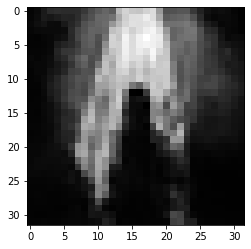

[('Chutney', 0.056618188), ('Pico de gallo', 0.05060785), ('Eggplant', 0.01853108), ('Tomato purée', 0.018184438), ('Orange', 0.015493969), ('Orange', 0.00957822), ('Fruit cup', 0.009564788), ('Berry', 0.00926149), ('Grenadine', 0.008635369), ('Paprika', 0.008526913)]
[('pomegranate', 0.38503724), ('Granny Smith', 0.3300334), ('orange', 0.102033086), ('buckeye, horse chestnut, conker', 0.033241436), ('hip, rose hip, rosehip', 0.03148989)]


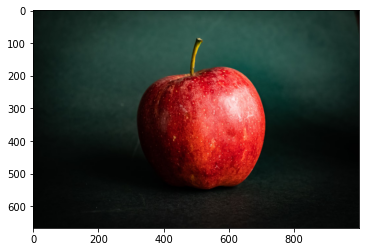

[('Air show', 0.006786483), ('Cat bed', 0.004247562), ('Human beard', 0.0034453447), ('Chameleon', 0.003256541), ('Iphone', 0.0025634302), ('Cheetah', 0.0023282007), ('Fang', 0.0022125398), ('Bullfighting', 0.0021987702), ('Pitch', 0.0020395026), ('Facial hair', 0.0019652152)]
[('Sussex spaniel', 0.08747719), ('muzzle', 0.031971168), ('otterhound, otter hound', 0.031613626), ('Yorkshire terrier', 0.030787243), ('toy terrier', 0.028148463)]


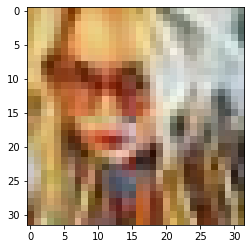

[('Burger king premium burgers', 0.006691923), ('Blended whiskey', 0.006305315), ('Presentation', 0.0035569423), ('Coca-cola', 0.0031528973), ('Bongo', 0.002586981), ('Cat bed', 0.0025732154), ('Air show', 0.0024902124), ('Guitar amplifier', 0.0021711108), ('Distilled beverage', 0.0021670957), ('Printmaking', 0.0020483972)]
[('nipple', 0.14548284), ('knee pad', 0.14082149), ('face powder', 0.06357408), ('barrel, cask', 0.046740685), ('milk can', 0.03222157)]


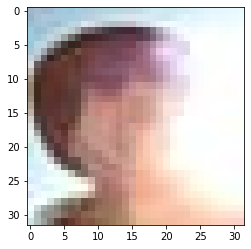

[('Air show', 0.005808199), ('Burger king premium burgers', 0.00513436), ('Match rifle shooting', 0.004688509), ('Armour', 0.0043808534), ('Ammunition', 0.004230834), ('Blended whiskey', 0.0037467636), ('Wolf', 0.0034694092), ('Cat bed', 0.0033455072), ('Coin', 0.0030041158), ('Antique', 0.0029856942)]
[('Japanese spaniel', 0.072853245), ('milk can', 0.059101243), ('revolver, six-gun, six-shooter', 0.04309664), ('affenpinscher, monkey pinscher, monkey dog', 0.03945356), ('whiskey jug', 0.026647974)]


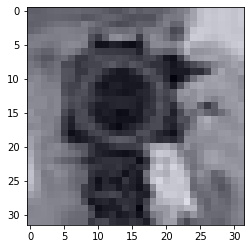

[('Battery', 0.021719659), ('Turbine', 0.013551039), ('Electrical supply', 0.009864081), ('Wheel', 0.009360176), ('Flash', 0.008828251), ('Flatweed', 0.008655071), ('Groupset', 0.00857948), ('Screwdriver', 0.008237605), ('Citroën ds', 0.0071827346), ('Electronics', 0.006908641)]
[('analog clock', 0.71938056), ('stopwatch, stop watch', 0.20321427), ('wall clock', 0.025488012), ('magnetic compass', 0.022878768), ('barometer', 0.0031130542)]


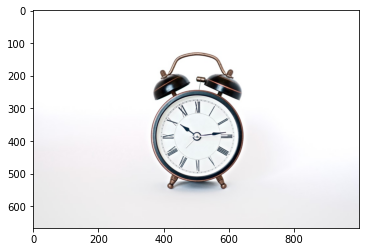

[('Facial hair', 0.013249283), ('Moustache', 0.009548202), ('Signature', 0.008470298), ('Dress suit', 0.007752587), ('Suit trousers', 0.006273849), ('Batman', 0.005628381), ('Boy', 0.0045618387), ('Woo woo', 0.004510275), ('Girl', 0.0044573536), ('Flash', 0.004292998)]
[('trench coat', 0.28085756), ('Windsor tie', 0.12287604), ('lab coat, laboratory coat', 0.05209907), ('sweatshirt', 0.049911615), ('bulletproof vest', 0.041150957)]


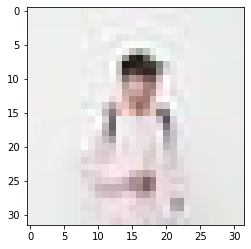

[('Portable media player', 0.04955497), ('Vehicle audio', 0.023075297), ('Citroën ds', 0.021311427), ('Usb flash drive', 0.018682357), ('Laptop', 0.00816034), ('Bmw 3 series', 0.006521074), ('Toyota land cruiser', 0.006057978), ('Volkswagen golf', 0.005239484), ('Volkswagen gti', 0.004620593), ('Fire extinguisher', 0.0044058273)]
[('mouse, computer mouse', 0.67078817), ('pencil sharpener', 0.100496575), ('switch, electric switch, electrical switch', 0.03224463), ('mousetrap', 0.018841986), ('cellular telephone, cellular phone, cellphone, cell, mobile phone', 0.016289981)]


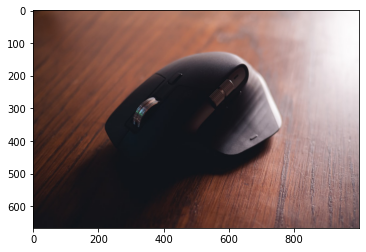

[('Rafting', 0.004276134), ('Bongo', 0.0035799893), ('Flash', 0.0025564635), ('Fashion model', 0.0025209873), ('Air show', 0.0023607507), ('Pitch', 0.002308392), ('Berbere', 0.002152389), ('Captain america', 0.0020473148), ('Watercraft', 0.0020219341), ('Beluga whale', 0.0019929186)]
[('red-breasted merganser, Mergus serrator', 0.54381263), ('black grouse', 0.048190825), ('chain saw, chainsaw', 0.03612916), ('grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus', 0.032097217), ('fox squirrel, eastern fox squirrel, Sciurus niger', 0.030413099)]


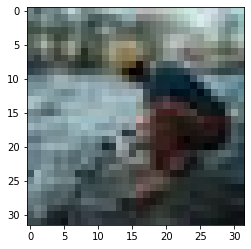

[('Pitch', 0.006316182), ('Rave', 0.0049068644), ('Air show', 0.0030820735), ('Blended whiskey', 0.0027690274), ('Panorama', 0.002709372), ('Kite', 0.0020419538), ('Propeller-driven aircraft', 0.0020212145), ('Netbook', 0.0019655246), ('Natural foods', 0.0019102913), ('Woodwind instrument', 0.0017717961)]
[('airliner', 0.08379067), ('screen, CRT screen', 0.07902465), ('axolotl, mud puppy, Ambystoma mexicanum', 0.054323442), ('space shuttle', 0.05075927), ('hand-held computer, hand-held microcomputer', 0.037891246)]


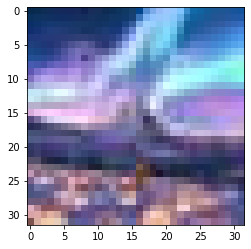

[('Blended whiskey', 0.011977596), ('Moustache', 0.011309062), ('Burger king premium burgers', 0.010825857), ('Facial hair', 0.009744959), ('Flash', 0.008355544), ('Iron man', 0.0067751915), ('Batman', 0.0052334215), ('Drawing', 0.0050563323), ('Guitar amplifier', 0.004961403), ('Ipad', 0.004285427)]
[('whistle', 0.08607584), ('can opener, tin opener', 0.0705073), ('muzzle', 0.063641995), ('tick', 0.05787195), ('maraca', 0.042560335)]


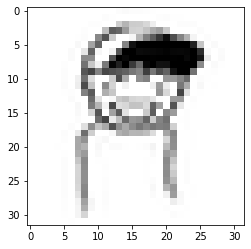

[('Match rifle shooting', 0.010764619), ('Rave', 0.0099440925), ('Alcoholic beverage', 0.008935211), ('Signature', 0.008015493), ('Air show', 0.006887464), ('Suit trousers', 0.0067378464), ('Dress suit', 0.0067345053), ('Moustache', 0.0067279222), ('Wolf', 0.0059409956), ('Batman', 0.005762732)]
[('Windsor tie', 0.34542182), ('bulletproof vest', 0.116271034), ('bolo tie, bolo, bola tie, bola', 0.08986032), ('pickelhaube', 0.06355204), ('trench coat', 0.04821776)]


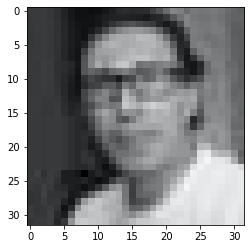

[('Mehndi', 0.0077110603), ('Blended whiskey', 0.0029623457), ('Pitch', 0.0027702646), ('Moustache', 0.0025500685), ('Bmw m3', 0.0023789494), ('Cope', 0.0021263699), ('Guitar amplifier', 0.0020941917), ('Wicket', 0.0020351144), ('Agave', 0.0020304767), ('Flash', 0.001973292)]
[('vase', 0.1153661), ('paintbrush', 0.046627812), ("academic gown, academic robe, judge's robe", 0.04535436), ('matchstick', 0.04130552), ('cloak', 0.039086662)]


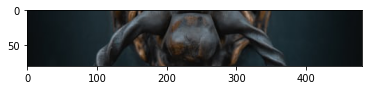

[('Match rifle shooting', 0.010049715), ('Roast beef', 0.007669559), ('Cat bed', 0.0076330528), ('Pub', 0.0076086624), ('Alcoholic beverage', 0.00532921), ('Blended whiskey', 0.0050972016), ('Signature', 0.005090631), ('Newcastle brown ale', 0.0043980284), ('Air show', 0.004384349), ('Presentation', 0.004136833)]
[('abaya', 0.058085408), ('fire screen, fireguard', 0.04860668), ('Windsor tie', 0.042964432), ('prison, prison house', 0.04282841), ('upright, upright piano', 0.032720644)]


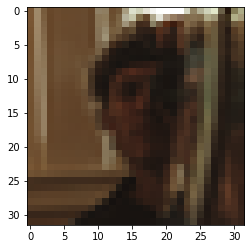

[('Wall sticker', 0.034408484), ('Drawing', 0.025540408), ('Pharmaceutical drug', 0.02310984), ('Class', 0.022127708), ('Graphics', 0.019392047), ('Packaging and labeling', 0.01829597), ('Self-help book', 0.01746733), ('Doodle', 0.014989358), ('Desk', 0.0143451905), ('Cat bed', 0.0126752425)]
[('menu', 0.2846871), ('comic book', 0.2821491), ('jigsaw puzzle', 0.056569487), ('envelope', 0.044516373), ('laptop, laptop computer', 0.030021759)]


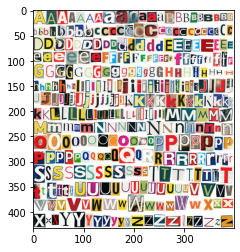

[('Desk', 0.024009598), ('Office supplies', 0.012543842), ('Tricking', 0.010765647), ('Self-help book', 0.010304201), ('School bus', 0.010098243), ('Printer', 0.009976784), ('Signage', 0.00851465), ('Class', 0.008487349), ('Cat bed', 0.007618528), ('Wall sticker', 0.0068670246)]
[('comic book', 0.17514668), ('book jacket, dust cover, dust jacket, dust wrapper', 0.11874792), ('crossword puzzle, crossword', 0.09180628), ('web site, website, internet site, site', 0.065370746), ('menu', 0.027580902)]


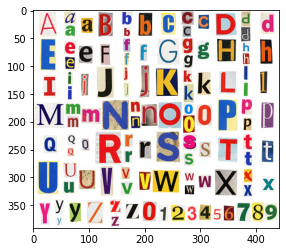

[('Shoal', 0.050905578), ('Aerostat', 0.050594542), ('Prom', 0.022480566), ('Hot air balloon', 0.02027422), ('Hot air ballooning', 0.018425576), ('Confetti', 0.011065156), ('Cheerleading', 0.010538978), ('Blimp', 0.00970113), ('Balloon', 0.008685649), ('Air gun', 0.008494438)]
[('balloon', 0.99971527), ('parachute, chute', 0.00028386878), ('umbrella', 5.9113273e-07), ('jellyfish', 1.4732345e-07), ('airship, dirigible', 9.871096e-08)]


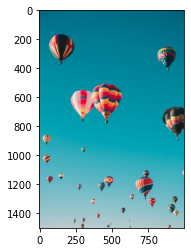

[('Burger king premium burgers', 0.01320637), ('Desk', 0.01225132), ('Printing', 0.0059187184), ("Potter's wheel", 0.00404671), ('Drawing', 0.0038891055), ('Mug', 0.003472129), ('Coffee table', 0.0033418515), ('Chutney', 0.0033007064), ('Dashi', 0.0031544368), ('Headphone ear pad', 0.0028206245)]
[('ballpoint, ballpoint pen, ballpen, Biro', 0.21310651), ('pencil box, pencil case', 0.20313638), ('rubber eraser, rubber, pencil eraser', 0.20237511), ('matchstick', 0.113138795), ('face powder', 0.042497955)]


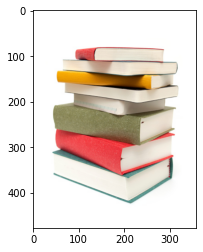

[('Line art', 0.010340825), ('Pattern', 0.0063203154), ('Stencil', 0.0050504883), ('Cross', 0.0048800358), ('Symmetry', 0.004593479), ('Cylinder', 0.0044705626), ('Pitch', 0.0037020422), ('Jewelry making', 0.0034915083), ('Pipe', 0.0033779773), ('Baluster', 0.0032542464)]
[('digital clock', 0.1794911), ('tray', 0.07038461), ('maze, labyrinth', 0.0696826), ('shower curtain', 0.052267358), ('doormat, welcome mat', 0.024606785)]


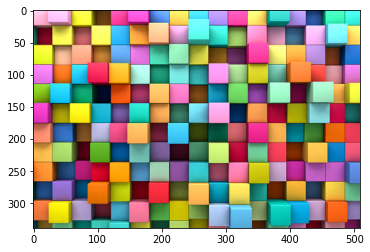

[('Signature', 0.009804244), ('Batman', 0.00876056), ('Iron man', 0.008458367), ('Moustache', 0.008103222), ('Flash', 0.006906056), ('Facial hair', 0.006046654), ('Dress suit', 0.0054491535), ('Captain america', 0.0048663453), ('Suit trousers', 0.004314611), ('Air show', 0.004120751)]
[('cloak', 0.24728741), ('Windsor tie', 0.10046474), ('sweatshirt', 0.09529725), ('trench coat', 0.05601018), ('abaya', 0.05336843)]


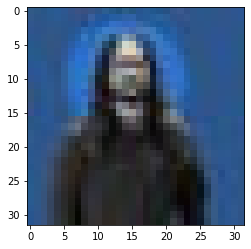

[('Jewelry making', 0.008087415), ('Platinum', 0.0052164723), ('Raft', 0.0048359577), ('Quilting', 0.00449381), ('Cat bed', 0.004468899), ('Drawing', 0.003621509), ('Woodwind instrument', 0.0036027299), ('Kart racing', 0.003498557), ('Twig', 0.0034515262), ('Lumber', 0.0032596542)]
[('paintbrush', 0.97046685), ('broom', 0.02786538), ('pencil sharpener', 0.00032154686), ('wool, woolen, woollen', 0.00028655704), ('umbrella', 0.00014812266)]


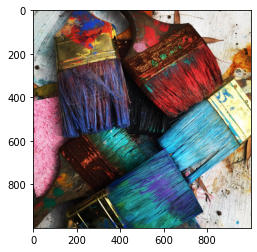

[('Couch', 0.38516173), ('Sideboard', 0.042508025), ('Air conditioning', 0.009054927), ('Stool', 0.009005555), ('Battery', 0.008603894), ('Jeep wrangler', 0.0069497717), ('Cabinetry', 0.006755326), ('Desk', 0.006455709), ('Video game console', 0.006119393), ('Wrangler', 0.0059509207)]
[('television, television system', 0.26365703), ('folding chair', 0.26343057), ('fire screen, fireguard', 0.106463805), ('spotlight, spot', 0.06682595), ('table lamp', 0.034955554)]


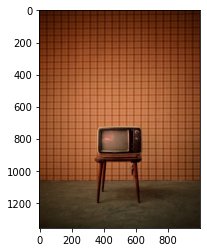

[('Stemware', 0.006036293), ('Transmitter station', 0.004398839), ('Bowling', 0.0040776674), ('Building', 0.0037640592), ('Line art', 0.0036429174), ('Battery', 0.003389687), ('Lock', 0.0032774527), ('Glass', 0.0031670115), ('Tennis Equipment', 0.0028589992), ('Gold', 0.0027435727)]
[('crossword puzzle, crossword', 0.9996137), ('maze, labyrinth', 0.00016548912), ('toilet tissue, toilet paper, bathroom tissue', 5.240701e-05), ('shower curtain', 3.0010378e-05), ('quilt, comforter, comfort, puff', 1.3342603e-05)]


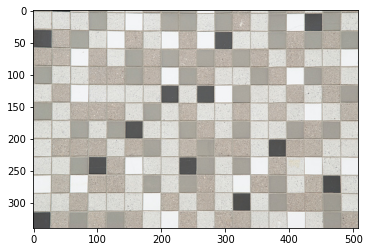

[('Fawn', 0.019063037), ('Barbie', 0.0153572485), ('Volkswagen gti', 0.010527002), ('Volkswagen r32', 0.010190411), ('Volkswagen golf', 0.010099389), ('Tennis Equipment', 0.007901547), ('Deer', 0.0074239806), ('Easter bunny', 0.0058079697), ('Prom', 0.005547841), ('Kuchen', 0.004977163)]
[('jigsaw puzzle', 0.879253), ('piggy bank, penny bank', 0.07909897), ('toyshop', 0.020068705), ('mask', 0.0065479698), ('rubber eraser, rubber, pencil eraser', 0.0059095756)]


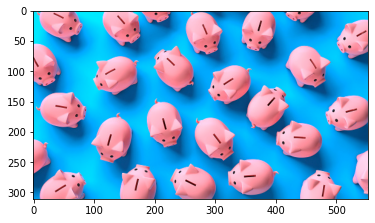

[('Facial hair', 0.045646735), ('Moustache', 0.015644776), ('Flash', 0.012880768), ('Batman', 0.01235455), ('Human beard', 0.010575885), ('Iron man', 0.009105261), ('Signature', 0.0073343907), ('Captain america', 0.006771814), ('Blended whiskey', 0.0059793033), ('Woo woo', 0.004858722)]
[('face powder', 0.2583439), ('neck brace', 0.07368244), ('sunscreen, sunblock, sun blocker', 0.060720664), ("loupe, jeweler's loupe", 0.049085338), ('waffle iron', 0.031734005)]


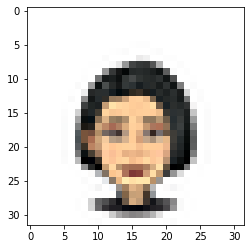

[('Burger king premium burgers', 0.00813069), ('Coin', 0.0051898053), ('Thigh', 0.0047444734), ('Rapid', 0.0047368063), ('Pitch', 0.0045239283), ('Netbook', 0.0042196475), ("Potter's wheel", 0.00409213), ('Chinese crested dog', 0.0036057162), ('Woodwind instrument', 0.0032982908), ('Blended whiskey', 0.0032419139)]
[('ocarina, sweet potato', 0.4539152), ('hair slide', 0.11829754), ('strainer', 0.08800546), ('lighter, light, igniter, ignitor', 0.07066503), ('saltshaker, salt shaker', 0.036858533)]


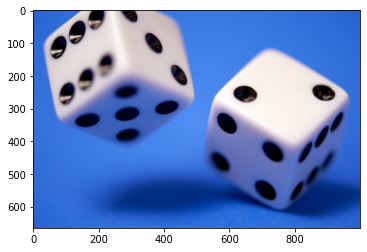

[('Burger king premium burgers', 0.00813069), ('Coin', 0.0051898053), ('Thigh', 0.0047444734), ('Rapid', 0.0047368063), ('Pitch', 0.0045239283), ('Netbook', 0.0042196475), ("Potter's wheel", 0.00409213), ('Chinese crested dog', 0.0036057162), ('Woodwind instrument', 0.0032982908), ('Blended whiskey', 0.0032419139)]
[('ocarina, sweet potato', 0.4539152), ('hair slide', 0.11829754), ('strainer', 0.08800546), ('lighter, light, igniter, ignitor', 0.07066503), ('saltshaker, salt shaker', 0.036858533)]


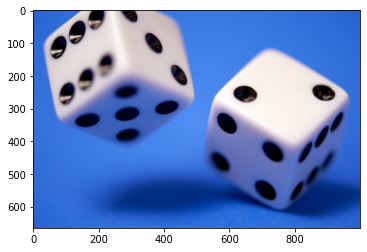

[('Signage', 0.0107598575), ('Desk', 0.009968082), ('Editing', 0.009551592), ('Printer', 0.009060156), ('Address sign', 0.0081594335), ('Video game console', 0.007818726), ('Wall sticker', 0.006848764), ('Tricking', 0.0066509545), ('Cat bed', 0.006223421), ('News', 0.0061365557)]
[('comic book', 0.14580202), ('web site, website, internet site, site', 0.09846115), ('book jacket, dust cover, dust jacket, dust wrapper', 0.08137017), ('menu', 0.07837257), ('crossword puzzle, crossword', 0.07093463)]


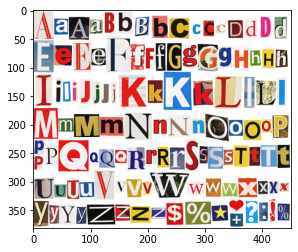

[('Drawing', 0.021377096), ('Mug', 0.011547234), ('Doodle', 0.007346557), ('Whiteboard', 0.0066498336), ('Coffee cup sleeve', 0.006319373), ('Desk', 0.0058036847), ('Fashion illustration', 0.005435615), ('Stencil', 0.005298254), ('Ceramic', 0.004927753), ('Construction equipment', 0.0046735574)]
[('cocktail shaker', 0.20707138), ('binder, ring-binder', 0.072762445), ('refrigerator, icebox', 0.048836235), ('coffee mug', 0.041112743), ('ballpoint, ballpoint pen, ballpen, Biro', 0.03744018)]


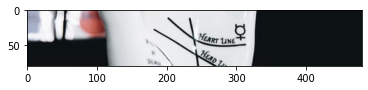

[('Scrap', 0.052981727), ('Portable media player', 0.028529989), ('Antique car', 0.017337026), ('Armored car', 0.0141468765), ('Battery', 0.013798305), ('Bulldozer', 0.013512329), ('Cadillac', 0.011858423), ('Armored car', 0.011137418), ('Volkswagen type 2', 0.011042924), ('Iphone', 0.010482981)]
[('space bar', 0.544486), ('typewriter keyboard', 0.4513276), ('dial telephone, dial phone', 0.0010596038), ('half track', 0.0007689295), ('waffle iron', 0.0002844033)]


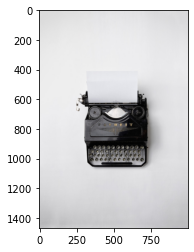

[('Fawn', 0.012179977), ('Barbie', 0.008008773), ('Deer', 0.0053172577), ('Drawing', 0.004619612), ('Orange', 0.004444213), ('Orange', 0.0038628392), ('Wall sticker', 0.0037724415), ('Vault', 0.0035435876), ('Eschscholzia californica', 0.003342857), ('Medal', 0.0031898743)]
[('rubber eraser, rubber, pencil eraser', 0.3292686), ('pick, plectrum, plectron', 0.2591226), ('jigsaw puzzle', 0.09958305), ('tray', 0.078782015), ('shower cap', 0.05437387)]


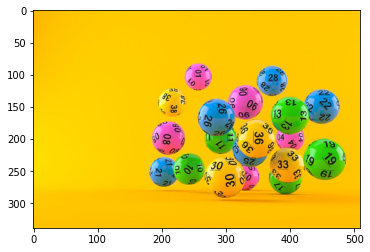

[('Moustache', 0.010052789), ('Blended whiskey', 0.009606051), ('Stout', 0.009026349), ('Signature', 0.008455413), ('Burger king premium burgers', 0.00792768), ('Flash', 0.007926051), ('Batman', 0.006310162), ('Facial hair', 0.005667687), ('Ipod', 0.0056347004), ('Online advertising', 0.0054289303)]
[('sunscreen, sunblock, sun blocker', 0.1298648), ('lotion', 0.10870289), ('hair spray', 0.058091816), ('cassette player', 0.05521154), ('Band Aid', 0.052565083)]


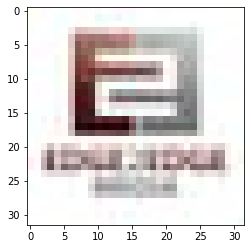

[('Shooter game', 0.010294409), ('Grenadier', 0.0071525397), ('Airsoft', 0.0071141412), ('Alcoholic beverage', 0.006951917), ('Machine gun', 0.0067825885), ('Firearm', 0.0066832574), ('Match rifle shooting', 0.006060506), ('Rave', 0.005817822), ('Batman', 0.00513503), ('Air show', 0.005028787)]
[('whiskey jug', 0.16816811), ('Windsor tie', 0.10847121), ('milk can', 0.10020902), ('revolver, six-gun, six-shooter', 0.09515609), ('punching bag, punch bag, punching ball, punchball', 0.08762937)]


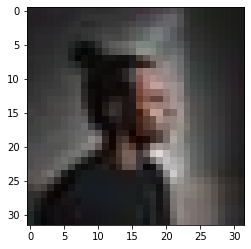

[('Mug', 0.15968582), ('Jug', 0.038080987), ('Ceramic', 0.01858178), ('Ristretto', 0.010981398), ('Kitchen utensil', 0.009651452), ('Teacup', 0.009238789), ('Verrine', 0.007860688), ('Cup', 0.0068303207), ('Cup', 0.005426028), ('Beer glass', 0.0046477807)]
[('pot, flowerpot', 0.55220646), ('cup', 0.13119818), ('vase', 0.060475986), ('mortar', 0.0555837), ('quill, quill pen', 0.028922375)]


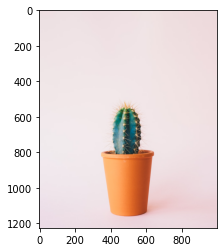

[('Rave', 0.027187368), ('Alcoholic beverage', 0.010223621), ('Poker set', 0.008952037), ('Air show', 0.008541699), ('Moustache', 0.006864171), ('Signature', 0.0066050687), ('Match rifle shooting', 0.0064844354), ('Presentation', 0.006220734), ('Batman', 0.006049109), ('Facial hair', 0.0057082004)]
[('neck brace', 0.082420364), ('bearskin, busby, shako', 0.07196659), ('Windsor tie', 0.06969878), ('bulletproof vest', 0.069474734), ('pickelhaube', 0.057960443)]


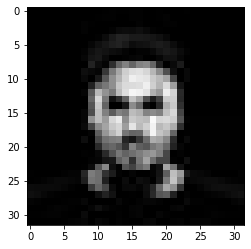

[('Mug', 0.045287624), ('Beer glass', 0.012034143), ('Cup', 0.011001294), ('Cup', 0.010907148), ('Battery', 0.008111577), ('Kitchen utensil', 0.00760489), ('Ristretto', 0.0071868594), ('Jug', 0.00713599), ('Burger king premium burgers', 0.006648437), ("Potter's wheel", 0.0059370766)]
[('hook, claw', 0.24378225), ('stethoscope', 0.21601844), ('corkscrew, bottle screw', 0.12333588), ('switch, electric switch, electrical switch', 0.061241545), ('ballpoint, ballpoint pen, ballpen, Biro', 0.038615312)]


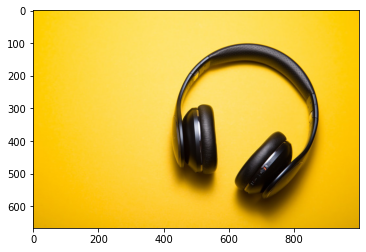

[('Presentation', 0.010018227), ('Air show', 0.008009229), ('Bongo', 0.0062309676), ('Cat bed', 0.0058217943), ('Roast beef', 0.005770256), ('Glen of imaal terrier', 0.0054485817), ('Stately home', 0.0045502265), ('Match rifle shooting', 0.004335166), ('Superbike racing', 0.004010118), ('Pub', 0.0035648814)]
[('Windsor tie', 0.14914727), ('English foxhound', 0.12129809), ('tobacco shop, tobacconist shop, tobacconist', 0.05915714), ('panpipe, pandean pipe, syrinx', 0.039577648), ('Walker hound, Walker foxhound', 0.0389034)]


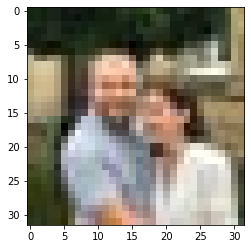

[('Presentation', 0.010018227), ('Air show', 0.008009229), ('Bongo', 0.0062309676), ('Cat bed', 0.0058217943), ('Roast beef', 0.005770256), ('Glen of imaal terrier', 0.0054485817), ('Stately home', 0.0045502265), ('Match rifle shooting', 0.004335166), ('Superbike racing', 0.004010118), ('Pub', 0.0035648814)]
[('Windsor tie', 0.14914727), ('English foxhound', 0.12129809), ('tobacco shop, tobacconist shop, tobacconist', 0.05915714), ('panpipe, pandean pipe, syrinx', 0.039577648), ('Walker hound, Walker foxhound', 0.0389034)]


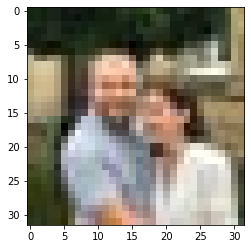

[('Verrine', 0.013444848), ('Ristretto', 0.00953425), ('Chutney', 0.00898991), ('American foxhound', 0.008108672), ('Fruit cup', 0.006357223), ('Tomato purée', 0.0047354433), ('Legume', 0.0046653347), ('Human arm', 0.004004613), ('Kitchen utensil', 0.0039543067), ('Pico de gallo', 0.0038154826)]
[('hip, rose hip, rosehip', 0.20837694), ('hook, claw', 0.1444543), ('bell pepper', 0.13823366), ('abacus', 0.05605309), ('pomegranate', 0.04695092)]


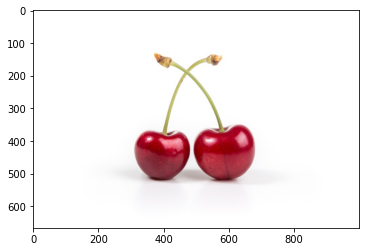

[('Burger king premium burgers', 0.009672114), ('Blended whiskey', 0.005221733), ('Flash', 0.0036721402), ('Moustache', 0.0032536478), ('Mannequin', 0.0031697243), ('Iron man', 0.0031137879), ('Roast beef', 0.0027448426), ('Air show', 0.002605249), ('Bongo', 0.0025868486), ('Shooter game', 0.0025824232)]
[('cocktail shaker', 0.07912613), ("loupe, jeweler's loupe", 0.0789877), ('pickelhaube', 0.07056242), ('breastplate, aegis, egis', 0.05048244), ('whiskey jug', 0.04368193)]


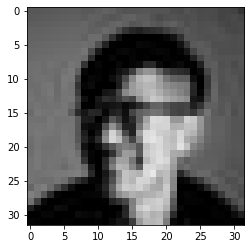

In [20]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline
#for im in range(0, 10):
for im in list(set(images)):
    try:
        # response = requests.get('https://picsum.photos/200/300?random=1')
        response = requests.get(im)
        img = Image.open(BytesIO(response.content))
    except:
        next
    
    i = transform(img) if img.mode == 'RGB' else None
    if type(i) == torch.Tensor:
        with torch.no_grad():

            regional_features = backbone(i)
            vgg_4096 = contextual(regional_features)
            biam_logits = biam(regional_features, vecs_7186, vgg_4096)
            img_net_logits = image_net_clf(vgg_4096)
            biam_probs = F.softmax(biam_logits, dim=1)
            img_net_probs = F.softmax(img_net_logits, dim=1)

        probabilities = biam_probs.cpu().numpy().reshape(-1)
        img_net_probabilities = img_net_probs.cpu().numpy().reshape(-1)
        order = np.flip(np.argsort(probabilities))
        order_imgnet = np.flip(np.argsort(img_net_probabilities))
        plt.figure()
        plt.imshow(img)
        print([(i, j) for i,j in zip(class_labels[order], probabilities[order])][0:10])
        print([(i,j) for i,j in zip(imagenet_cls[order_imgnet], img_net_probabilities[order_imgnet])][0:5])
        plt.show()
                                           


In [ ]:
response = requests.get(im)
img = Image.open(BytesIO(response.content))
i = transform(img) if img.mode == 'RGB' else None
if type(img) == torch.Tensor:
    with torch.no_grad():

        regional_features = backbone(img)
        vgg_4096 = contextual(regional_features)
        biam_logits = biam(regional_features, vecs_7186, vgg_4096)
        img_net_logits = image_net_clf(vgg_4096)
        biam_probs = F.softmax(biam_logits, dim=1)
        img_net_probs = F.softmax(img_net_logits, dim=1)

    probabilities = biam_probs.cpu().numpy().reshape(-1)
    order = np.flip(np.argsort(probabilities))
    display(Image(img))